In [2]:
!unzip -q drive/MyDrive/MIL/Pascal-part.zip
!pip install -qr requirements.txt

     |████████████████████████████████| 446 kB 33.5 MB/s 
     |████████████████████████████████| 97 kB 8.6 MB/s 
     |████████████████████████████████| 148 kB 72.0 MB/s 
     |████████████████████████████████| 125 kB 75.1 MB/s 
     |████████████████████████████████| 58 kB 751 kB/s 
     |████████████████████████████████| 376 kB 66.6 MB/s 


In [1]:
import re
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch import nn, optim
from itertools import chain
import albumentations as albu
import matplotlib.pyplot as plt
from catalyst.metrics import iou
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from catalyst.contrib.losses import DiceLoss, IoULoss
from albumentations.pytorch import ToTensorV2 as ToTensor
from catalyst.callbacks import (DiceCallback, 
                                IOUCallback, 
                                CriterionCallback,
                                MetricAggregationCallback, 
                                OptimizerCallback)
from utils import(create_sample, 
                  extract_ids, 
                  split_sample, 
                  PascalDataset, 
                  visualize, 
                  PascalRunner, 
                  extract_masks, 
                  extract_masks_label)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
src_path = Path("Pascal-part")
image_path = src_path / "JPEGImages"
mask_path = src_path / "gt_masks"

image_names = create_sample(image_path)
mask_names = create_sample(mask_path)

In [4]:
train_ids = extract_ids(src_path / "train_id.txt")
val_ids = extract_ids(src_path / "val_id.txt")

image_names_train, image_names_val = split_sample(image_names, train_ids, val_ids)
mask_names_train, mask_names_val = split_sample(mask_names, train_ids, val_ids)

In [5]:
classes = []
with open(src_path / "classes.txt") as file:
    for line in file:
        classes.append(re.sub("[^a-z_]+", "", line))

classes

['bg', 'low_hand', 'torso', 'low_leg', 'head', 'up_leg', 'up_hand']

In [6]:
p = 0.3
image_size = 224

train_transforms = albu.Compose([
    albu.RandomResizedCrop(image_size, image_size),
    albu.Rotate(p=p),
    albu.HorizontalFlip(p=p),
    albu.VerticalFlip(p=p), 
    albu.GaussianBlur(p=p),
    albu.Normalize(),
    ToTensor()
])

val_transforms = albu.Compose([
    albu.Resize(image_size, image_size),
    albu.Normalize(),
    ToTensor()
])

train_dataset = PascalDataset(image_names_train, mask_names_train, transform=train_transforms)
val_dataset = PascalDataset(image_names_val, mask_names_val, "val", val_transforms)

Посмотрим на распределение в классах:

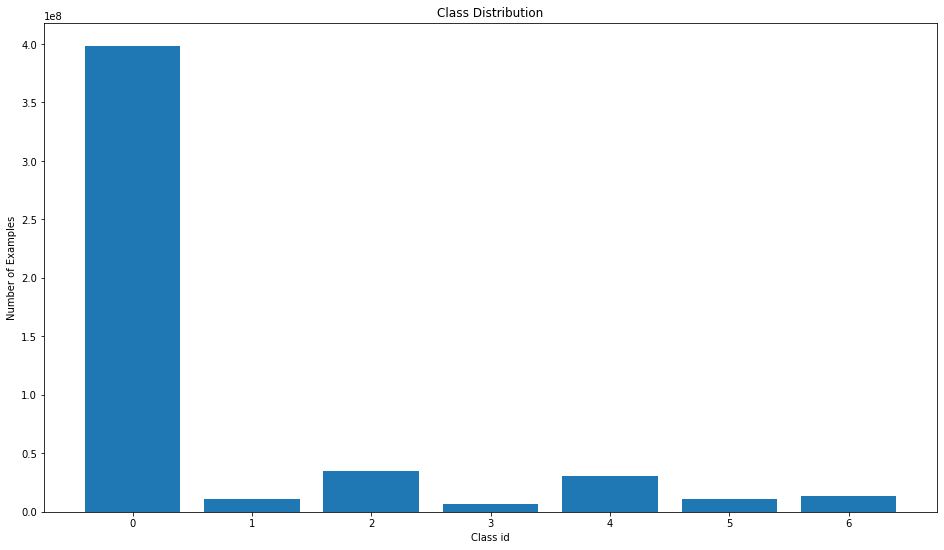

In [7]:
plt.figure(figsize=(16, 9))
plt.title("Сlass Distribution")
plt.ylabel("Number of Examples")
plt.xlabel("Class id")
plt.bar(train_dataset.label_counter.keys(), train_dataset.label_counter.values())
plt.show()

Как ожидало, присутствует сильный дисбаланс, чтобы модель обращала внимание на редкие объекты и не подгонялась под частые, в функцию потерь будем передавать [взвешивание](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html#sklearn-utils-class-weight-compute-class-weight):

In [8]:
n_classes = train_dataset.n_classes
counts_sorted = sorted(train_dataset.label_counter.items(), key=lambda x: x[0])
label_counts = list(map(lambda x: x[1], counts_sorted))
n_samples = sum(label_counts)

class_weights = torch.FloatTensor([n_samples / (n_classes * label_count) for label_count in label_counts]).to(device)
class_weights

tensor([ 0.1813,  6.5277,  2.0799, 11.0395,  2.3868,  6.3662,  5.4128],
       device='cuda:0')

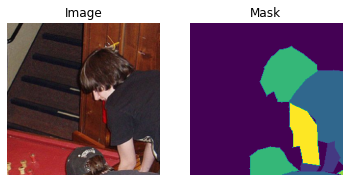

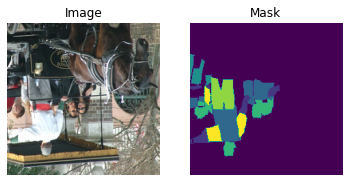

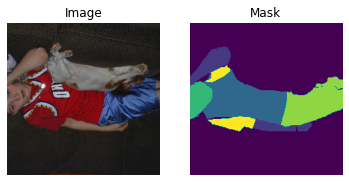

In [9]:
np.random.seed(42)
n_examples = 3

for i in range(n_examples):
    image, mask, mask_expanded = np.random.choice(train_dataset).values()
    visualize(image, mask, figsize=(6, 6))

В качестве функции потерь будем оптимизировать следующую комбинацию: $IoU + Dice + 0.8*CE_w$.

In [10]:
num_epochs = 10
batch_size = 32
num_workers = 2
threshold = 0.5
logdir = "./logs/segmentation"

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}

criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "ce": nn.CrossEntropyLoss(class_weights)
}

model = smp.Unet("resnet50", classes=n_classes, activation=nn.Softmax2d)

optimizer = optim.Adam(
    (
        {
            "params": chain(model.encoder.parameters(), model.decoder.parameters()),
            "lr": 1e-4,
        },
        {
            "params": model.segmentation_head.parameters(),
            "lr" : 1e-2
        }
     )
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

callbacks = [
    CriterionCallback("pred", "mask_expanded", "loss_dice", "dice"),
    CriterionCallback("pred", "mask_expanded", "loss_iou", "iou"),
    CriterionCallback("pred", "mask", "loss_ce", "ce"),
    MetricAggregationCallback(
        "loss",
        {"loss_dice": 1.0, "loss_iou": 1.0, "loss_ce": 0.8},
        "weighted_sum"
        ),
    DiceCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    IOUCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    OptimizerCallback("loss")
]

runner = PascalRunner(input_key="image", output_key="pred",
                      output_mask_key="pred_mask", target_key="mask", 
                      device=device)

In [11]:
runner.train(
    loaders=loaders,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    num_epochs=num_epochs,
    logdir=logdir,
    valid_loader="valid",
    valid_metric="iou",
    minimize_valid_metric=False,
    verbose=True
)

1/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (1/10) dice: 0.3782014548778534 | dice/_macro: 0.3782014548778534 | dice/_micro: 0.7502374649047852 | iou: 0.27765682339668274 | iou/_macro: 0.27765682339668274 | iou/_micro: 0.600304126739502 | loss: 2.785308361053467 | loss_ce: 1.753217899706544 | loss_ce/mean: 1.753217899706544 | loss_ce/std: 0.08330817004653006 | loss_dice: 0.6466840690783553 | loss_dice/mean: 0.6466840690783553 | loss_dice/std: 0.08848984614802023 | loss_iou: 0.7360502560764702 | loss_iou/mean: 0.7360502560764702 | loss_iou/std: 0.07069529783894611 | lr: 0.0001 | momentum: 0.9


1/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (1/10) dice: 0.5145119428634644 | dice/_macro: 0.5145119428634644 | dice/_micro: 0.8222243785858154 | iou: 0.3890114426612854 | iou/_macro: 0.3890114426612854 | iou/_micro: 0.6981163620948792 | loss: 2.4180548191070557 | loss_ce: 1.6054631689144496 | loss_ce/mean: 1.6054631689144496 | loss_ce/std: 0.03192423175003698 | loss_dice: 0.5065629185510659 | loss_dice/mean: 0.5065629185510659 | loss_dice/std: 0.02773526740371469 | loss_iou: 0.6271213711235446 | loss_iou/mean: 0.6271213711235446 | loss_iou/std: 0.02335493108092718 | lr: 0.0001 | momentum: 0.9
* Epoch (1/10) lr: 0.0001 | momentum: 0.9


2/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (2/10) dice: 0.4792533814907074 | dice/_macro: 0.4792533814907074 | dice/_micro: 0.7901570200920105 | iou: 0.3570496141910553 | iou/_macro: 0.3570496141910553 | iou/_micro: 0.6531070470809937 | loss: 2.496915817260742 | loss_ce: 1.6538755949388892 | loss_ce/mean: 1.6538755949388892 | loss_ce/std: 0.04928277939347614 | loss_dice: 0.5276738495077549 | loss_dice/mean: 0.5276738495077549 | loss_dice/std: 0.04003504687206198 | loss_iou: 0.6461415696211595 | loss_iou/mean: 0.6461415696211595 | loss_iou/std: 0.03446842710546636 | lr: 0.0001 | momentum: 0.9


2/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (2/10) dice: 0.5483307242393494 | dice/_macro: 0.5483307242393494 | dice/_micro: 0.8437166810035706 | iou: 0.4176810085773468 | iou/_macro: 0.4176810085773468 | iou/_micro: 0.7296799421310425 | loss: 2.3128225803375244 | loss_ce: 1.5672529838041336 | loss_ce/mean: 1.5672529838041336 | loss_ce/std: 0.031553944472085524 | loss_dice: 0.4657829459519501 | loss_dice/mean: 0.4657829459519501 | loss_dice/std: 0.031592996787204966 | loss_iou: 0.5932371992370195 | loss_iou/mean: 0.5932371992370195 | loss_iou/std: 0.027424880908196784 | lr: 0.0001 | momentum: 0.9
* Epoch (2/10) lr: 0.0001 | momentum: 0.9


3/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (3/10) dice: 0.5090143084526062 | dice/_macro: 0.5090143084526062 | dice/_micro: 0.805909276008606 | iou: 0.38234859704971313 | iou/_macro: 0.38234859704971313 | iou/_micro: 0.674914538860321 | loss: 2.415940761566162 | loss_ce: 1.6226267890565718 | loss_ce/mean: 1.6226267890565718 | loss_ce/std: 0.053694642094722994 | loss_dice: 0.4974666257235317 | loss_dice/mean: 0.4974666257235317 | loss_dice/std: 0.03946300275374685 | loss_iou: 0.620372636387387 | loss_iou/mean: 0.620372636387387 | loss_iou/std: 0.03336850869276516 | lr: 0.0001 | momentum: 0.9


3/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (3/10) dice: 0.5673636794090271 | dice/_macro: 0.5673636794090271 | dice/_micro: 0.846288800239563 | iou: 0.4337174594402313 | iou/_macro: 0.4337174594402313 | iou/_micro: 0.7335360646247864 | loss: 2.2511773109436035 | loss_ce: 1.5394416887318396 | loss_ce/mean: 1.5394416887318396 | loss_ce/std: 0.038212681271457806 | loss_dice: 0.4444239116794149 | loss_dice/mean: 0.4444239116794149 | loss_dice/std: 0.035857395742273965 | loss_iou: 0.5752001557356904 | loss_iou/mean: 0.5752001557356904 | loss_iou/std: 0.03075174105146626 | lr: 0.0001 | momentum: 0.9
* Epoch (3/10) lr: 0.0001 | momentum: 0.9


4/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (4/10) dice: 0.5246531367301941 | dice/_macro: 0.5246531367301941 | dice/_micro: 0.8140620589256287 | iou: 0.3930359482765198 | iou/_macro: 0.3930359482765198 | iou/_micro: 0.6864289045333862 | loss: 2.3744215965270996 | loss_ce: 1.6064486393925157 | loss_ce/mean: 1.6064486393925157 | loss_ce/std: 0.05476593134039095 | loss_dice: 0.48067994781697965 | loss_dice/mean: 0.48067994781697965 | loss_dice/std: 0.03869146050331079 | loss_iou: 0.6085827643788629 | loss_iou/mean: 0.6085827643788629 | loss_iou/std: 0.03370013520243554 | lr: 0.0001 | momentum: 0.9


4/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (4/10) dice: 0.5903119444847107 | dice/_macro: 0.5903119444847107 | dice/_micro: 0.8592434525489807 | iou: 0.45284369587898254 | iou/_macro: 0.45284369587898254 | iou/_micro: 0.7532225847244263 | loss: 2.1953177452087402 | loss_ce: 1.523671329948824 | loss_ce/mean: 1.523671329948824 | loss_ce/std: 0.04144956803248264 | loss_dice: 0.4209262141075296 | loss_dice/mean: 0.4209262141075296 | loss_dice/std: 0.037193499368575536 | loss_iou: 0.5554544930748082 | loss_iou/mean: 0.5554544930748082 | loss_iou/std: 0.03319192669397816 | lr: 0.0001 | momentum: 0.9
* Epoch (4/10) lr: 0.0001 | momentum: 0.9


5/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (5/10) dice: 0.550134539604187 | dice/_macro: 0.550134539604187 | dice/_micro: 0.8276605010032654 | iou: 0.41696029901504517 | iou/_macro: 0.41696029901504517 | iou/_micro: 0.7059904932975769 | loss: 2.313239574432373 | loss_ce: 1.5888178740843588 | loss_ce/mean: 1.5888178740843588 | loss_ce/std: 0.05170004339328505 | loss_dice: 0.4563783874177628 | loss_dice/mean: 0.4563783874177628 | loss_dice/std: 0.036595882499146665 | loss_iou: 0.585806903228301 | loss_iou/mean: 0.585806903228301 | loss_iou/std: 0.03300187886976871 | lr: 0.0001 | momentum: 0.9


5/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (5/10) dice: 0.5906597971916199 | dice/_macro: 0.5906597971916199 | dice/_micro: 0.8556021451950073 | iou: 0.4539622664451599 | iou/_macro: 0.4539622664451599 | iou/_micro: 0.7476439476013184 | loss: 2.1862707138061523 | loss_ce: 1.5122575539004852 | loss_ce/mean: 1.5122575539004852 | loss_ce/std: 0.03430134578372216 | loss_dice: 0.4211184168300332 | loss_dice/mean: 0.4211184168300332 | loss_dice/std: 0.03465159133959611 | loss_iou: 0.555346366961235 | loss_iou/mean: 0.555346366961235 | loss_iou/std: 0.03088420172398857 | lr: 0.0001 | momentum: 0.9
* Epoch (5/10) lr: 5e-05 | momentum: 0.9


6/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (6/10) dice: 0.5611938834190369 | dice/_macro: 0.5611938834190369 | dice/_micro: 0.8285573124885559 | iou: 0.4253627359867096 | iou/_macro: 0.4253627359867096 | iou/_micro: 0.7072964906692505 | loss: 2.2853360176086426 | loss_ce: 1.578649170754737 | loss_ce/mean: 1.578649170754737 | loss_ce/std: 0.05858117888741375 | loss_dice: 0.4455014682372918 | loss_dice/mean: 0.4455014682372918 | loss_dice/std: 0.04707863152583131 | loss_iou: 0.576915399537218 | loss_iou/mean: 0.576915399537218 | loss_iou/std: 0.041303635969289515 | lr: 5e-05 | momentum: 0.9


6/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (6/10) dice: 0.6136109232902527 | dice/_macro: 0.6136109232902527 | dice/_micro: 0.8628144860267639 | iou: 0.4738762378692627 | iou/_macro: 0.4738762378692627 | iou/_micro: 0.75872802734375 | loss: 2.124235153198242 | loss_ce: 1.4897626073559407 | loss_ce/mean: 1.4897626073559407 | loss_ce/std: 0.03228721240742528 | loss_dice: 0.3977066247264263 | loss_dice/mean: 0.3977066247264263 | loss_dice/std: 0.0314629084648952 | loss_iou: 0.5347184179695864 | loss_iou/mean: 0.5347184179695864 | loss_iou/std: 0.027985697439280324 | lr: 5e-05 | momentum: 0.9
* Epoch (6/10) lr: 5e-05 | momentum: 0.9


7/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (7/10) dice: 0.5850710868835449 | dice/_macro: 0.5850710868835449 | dice/_micro: 0.8425130844116211 | iou: 0.44854578375816345 | iou/_macro: 0.44854578375816345 | iou/_micro: 0.7278813719749451 | loss: 2.22741436958313 | loss_ce: 1.5635388701500323 | loss_ce/mean: 1.5635388701500323 | loss_ce/std: 0.056423553510205254 | loss_dice: 0.4222957325673492 | loss_dice/mean: 0.4222957325673492 | loss_dice/std: 0.041598650603361424 | loss_iou: 0.5542875391662501 | loss_iou/mean: 0.5542875391662501 | loss_iou/std: 0.03827749387529143 | lr: 5e-05 | momentum: 0.9


7/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (7/10) dice: 0.6231197118759155 | dice/_macro: 0.6231197118759155 | dice/_micro: 0.8703036904335022 | iou: 0.48444199562072754 | iou/_macro: 0.48444199562072754 | iou/_micro: 0.7703874111175537 | loss: 2.102433681488037 | loss_ce: 1.4867766105808327 | loss_ce/mean: 1.4867766105808327 | loss_ce/std: 0.03655275451328619 | loss_dice: 0.38839423985258703 | loss_dice/mean: 0.38839423985258703 | loss_dice/std: 0.030896726769702385 | loss_iou: 0.5246181090110769 | loss_iou/mean: 0.5246181090110769 | loss_iou/std: 0.028963439635375076 | lr: 5e-05 | momentum: 0.9
* Epoch (7/10) lr: 5e-05 | momentum: 0.9


8/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (8/10) dice: 0.5913556218147278 | dice/_macro: 0.5913556218147278 | dice/_micro: 0.8469579219818115 | iou: 0.4540310502052307 | iou/_macro: 0.4540310502052307 | iou/_micro: 0.7345420718193054 | loss: 2.2056567668914795 | loss_ce: 1.553813128292518 | loss_ce/mean: 1.553813128292518 | loss_ce/std: 0.05124873427489031 | loss_dice: 0.4148596005918957 | loss_dice/mean: 0.4148596005918957 | loss_dice/std: 0.04125630314552616 | loss_iou: 0.5477466384147974 | loss_iou/mean: 0.5477466384147974 | loss_iou/std: 0.03801139050538077 | lr: 5e-05 | momentum: 0.9


8/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (8/10) dice: 0.6393908262252808 | dice/_macro: 0.6393908262252808 | dice/_micro: 0.884804368019104 | iou: 0.5009034872055054 | iou/_macro: 0.5009034872055054 | iou/_micro: 0.7934073805809021 | loss: 2.0785582065582275 | loss_ce: 1.4978218992494963 | loss_ce/mean: 1.4978218992494963 | loss_ce/std: 0.038854394773409004 | loss_dice: 0.37203926328553844 | loss_dice/mean: 0.37203926328553844 | loss_dice/std: 0.03281447240328939 | loss_iou: 0.5082613948885419 | loss_iou/mean: 0.5082613948885419 | loss_iou/std: 0.03050739983236223 | lr: 5e-05 | momentum: 0.9
* Epoch (8/10) lr: 5e-05 | momentum: 0.9


9/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (9/10) dice: 0.6050308346748352 | dice/_macro: 0.6050308346748352 | dice/_micro: 0.8527019619941711 | iou: 0.46712130308151245 | iou/_macro: 0.46712130308151245 | iou/_micro: 0.7432262897491455 | loss: 2.1683554649353027 | loss_ce: 1.538983147530714 | loss_ce/mean: 1.538983147530714 | loss_ce/std: 0.05591465002262006 | loss_dice: 0.40174642523720344 | loss_dice/mean: 0.40174642523720344 | loss_dice/std: 0.04171610802346814 | loss_iou: 0.5354224565766503 | loss_iou/mean: 0.5354224565766503 | loss_iou/std: 0.03797153849364888 | lr: 5e-05 | momentum: 0.9


9/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (9/10) dice: 0.6362037658691406 | dice/_macro: 0.6362037658691406 | dice/_micro: 0.8784993290901184 | iou: 0.4982374310493469 | iou/_macro: 0.4982374310493469 | iou/_micro: 0.7833247780799866 | loss: 2.0700390338897705 | loss_ce: 1.4836528825624997 | loss_ce/mean: 1.4836528825624997 | loss_ce/std: 0.0322348049922416 | loss_dice: 0.3736554183582268 | loss_dice/mean: 0.3736554183582268 | loss_dice/std: 0.0315376703881921 | loss_iou: 0.5094612870560338 | loss_iou/mean: 0.5094612870560338 | loss_iou/std: 0.028609151333452893 | lr: 5e-05 | momentum: 0.9
* Epoch (9/10) lr: 2.5e-05 | momentum: 0.9


10/10 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (10/10) dice: 0.6084009408950806 | dice/_macro: 0.6084009408950806 | dice/_micro: 0.8552705645561218 | iou: 0.4699396789073944 | iou/_macro: 0.4699396789073944 | iou/_micro: 0.7471377849578857 | loss: 2.163239002227783 | loss_ce: 1.5433478897881698 | loss_ce/mean: 1.5433478897881698 | loss_ce/std: 0.05901159436176819 | loss_dice: 0.39680385640219273 | loss_dice/mean: 0.39680385640219273 | loss_dice/std: 0.0391847643530767 | loss_iou: 0.5317569587218869 | loss_iou/mean: 0.5317569587218869 | loss_iou/std: 0.036645780205213495 | lr: 2.5e-05 | momentum: 0.9


10/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (10/10) dice: 0.6469330787658691 | dice/_macro: 0.6469330787658691 | dice/_micro: 0.8855805993080139 | iou: 0.5085329413414001 | iou/_macro: 0.5085329413414001 | iou/_micro: 0.7946563959121704 | loss: 2.049928665161133 | loss_ce: 1.4833331502647344 | loss_ce/mean: 1.4833331502647344 | loss_ce/std: 0.039944197147462474 | loss_dice: 0.36347338982990807 | loss_dice/mean: 0.36347338982990807 | loss_dice/std: 0.034045163594348296 | loss_iou: 0.49978871729957325 | loss_iou/mean: 0.49978871729957325 | loss_iou/std: 0.03216352877945134 | lr: 2.5e-05 | momentum: 0.9
* Epoch (10/10) lr: 2.5e-05 | momentum: 0.9
Top models:
./logs/segmentation/checkpoints/model.0010.pth	0.5085


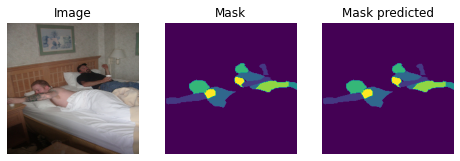

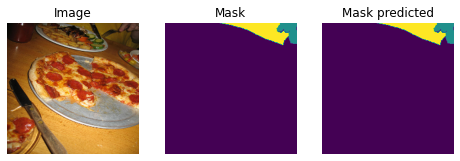

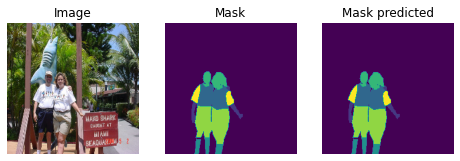

In [12]:
np.random.seed(42)

for i in range(n_examples):
    data = np.random.choice(val_dataset)
    dl = DataLoader([data])
    image, mask, mask_expanded = data.values()
    pred_mask = torch.cat(list(runner.predict_loader(dl))).cpu().squeeze()
    visualize(image, mask, pred_mask)

In [13]:
true_masks = torch.cat(list(extract_masks(val_dataloader))).to(device)
predicted_masks = torch.cat(list(runner.predict_loader(val_dataloader)))

In [14]:
body_labels = [[1, 6, 2, 4, 3, 5]]
up_low_labels = [[1, 6, 2, 4], [3, 5]]
parts_labels = list(range(1, 7))

true_masks0 = torch.stack(list(extract_masks_label(true_masks, body_labels)))
true_masks1 = torch.stack(list(extract_masks_label(true_masks, up_low_labels)))
true_masks2 = torch.stack(list(extract_masks_label(true_masks, parts_labels)))

predicted_masks0 = torch.stack(list(extract_masks_label(predicted_masks, body_labels)))
predicted_masks1 = torch.stack(list(extract_masks_label(predicted_masks, up_low_labels)))
predicted_masks2 = torch.stack(list(extract_masks_label(predicted_masks, parts_labels)))

In [15]:
iou0 = dict(zip(["body"], iou(true_masks0, predicted_masks0).cpu().numpy().round(3)))
pd.DataFrame(iou0, index=["iou0"])

,body
iou0,0.732


In [16]:
iou1 = dict(zip(["upper_body", "lower_body"], iou(true_masks1, predicted_masks1).cpu().numpy().round(3)))
pd.DataFrame(iou1, index=["iou1"])

,upper_body,lower_body
iou1,0.74,0.396


In [17]:
iou2 = dict(zip(classes[1:], iou(true_masks2, predicted_masks2).cpu().numpy().round(3)))
pd.DataFrame(iou2, index=["iou"])

,low_hand,torso,low_leg,head,up_leg,up_hand
iou,0.381,0.509,0.278,0.777,0.32,0.381
